# ML Group Project

In [31]:
#https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap
import statistics as stat
import numpy as np
import pandas as pd
import Helper_Function as hf #File with custom-built functions
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="darkgrid")

file_path_1 = '/Users/andrewmartinez/Documents/MBD/Machine Learning II/Group Project/Labels.csv'
file_path_2 = '/Users/andrewmartinez/Documents/MBD/Machine Learning II/Group Project/Train.csv'

#Dataiku nulls out amount_tsv, need to keep original set
file_path_3 = '/Users/andrewmartinez/Documents/MBD/Machine Learning II/Group Project/Train_prepared.csv'

labels = hf.read_data(file_path_1)
raw_df = hf.read_data(file_path_2)

#External Data
pop_df = pd.read_excel('External_features.xls', sheet_name = 0)
weather_df = pd.read_excel('External_features.xls', sheet_name = 1)

raw_df.describe(include = 'all')

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400.000000,59400.000000,59400,59400,59400.000000,59400,59400.000000,5.940000e+04,59400,59400.000000,...,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,NaN,NaN,356,1898,NaN,2146,NaN,NaN,37400,NaN,...,7,8,6,5,5,10,7,3,7,6
top,NaN,NaN,3/15/11,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,NaN,NaN,572,9084,NaN,17402,NaN,NaN,3563,NaN,...,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625
mean,37115.131768,317.650385,NaN,NaN,668.297239,NaN,34.077427,-5.706033e+00,NaN,0.474141,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,21453.128371,2997.574558,NaN,NaN,693.116350,NaN,6.567432,2.946019e+00,NaN,12.236230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,NaN,NaN,-90.000000,NaN,0.000000,-1.164944e+01,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,18519.750000,0.000000,NaN,NaN,0.000000,NaN,33.090347,-8.540621e+00,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,37061.500000,0.000000,NaN,NaN,369.000000,NaN,34.908743,-5.021597e+00,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,55656.500000,20.000000,NaN,NaN,1319.250000,NaN,37.178387,-3.326156e+00,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
raw_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,3/14/11,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,3/6/13,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2/25/13,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,1/28/13,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,7/13/11,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [33]:
pop_df.head()

,Name,Abbr.,Status,Capital,Area_KM2,Population2002,Population2012,Increase 2002 - 2012,Pop_Density2012,Population2016
0,Tanzania,TZA,Rep,Dodoma,885803,34443603,44928923,0.304420,50.721123,50144200
1,Arusha,ARU,Reg,Arusha,37576,1288088,1694310,0.315368,45.090217,1890700
2,Dar es Salaam,DAR,Reg,Dar es Salaam,1393,2487288,4364541,0.754739,3133.195262,5465400
3,Dodoma,DOD,Reg,Dodoma,41311,1692025,2083588,0.231417,50.436639,2264500
4,Geita,GEI,Reg,Geita,20054,1337718,1739530,0.300371,86.742296,1932200


In [34]:
weather_df.head()

,Month_num,Month,Temp_Min,Temp_max,rainy_days,total_rain_mm
0,1,January,18.6,29.4,10,133.7
1,2,February,18.6,29.4,9,144.5
2,3,March,18.3,29.0,7,113.9
3,4,April,17.9,28.7,5,57.8
4,5,May,16.5,28.0,1,5.3


In [35]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   59400 non-null object
gps_height               59400 non-null int64
installer                59400 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59400 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           59400 non-null object
r

In [36]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
id              59400 non-null int64
status_group    59400 non-null object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [37]:
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 10 columns):
Name                    27 non-null object
Abbr.                   27 non-null object
Status                  27 non-null object
Capital                 27 non-null object
Area_KM2                27 non-null int64
Population2002          27 non-null int64
Population2012          27 non-null int64
Increase 2002 - 2012    27 non-null float64
Pop_Density2012         27 non-null float64
Population2016          27 non-null int64
dtypes: float64(2), int64(4), object(4)
memory usage: 2.2+ KB


In [38]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
Month_num        12 non-null int64
Month            12 non-null object
Temp_Min         12 non-null float64
Temp_max         12 non-null float64
rainy_days       12 non-null int64
total_rain_mm    12 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 656.0+ bytes


In [39]:
raw_df = raw_df.drop('date_recorded', axis = 1)
clean_df = hf.read_data(file_path_3)
cols = ['id', 'date_recorded', 'Year', 'Month', 'Day', 'Day_of_week']
dates = clean_df[cols]
dates_df = pd.merge(dates, raw_df, how = 'inner', on ='id') 
dates_df.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


,id,date_recorded,Year,Month,Day,Day_of_week,amount_tsh,funder,gps_height,installer,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,2011-03-14T00:00:00.000Z,2011,3,14,1,6000.0,Roman,1390,Roman,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,2013-03-06T00:00:00.000Z,2013,3,6,3,0.0,Grumeti,1399,GRUMETI,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,2013-02-25T00:00:00.000Z,2013,2,25,1,25.0,Lottery Club,686,World vision,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,2013-01-28T00:00:00.000Z,2013,1,28,1,0.0,Unicef,263,UNICEF,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,2011-07-13T00:00:00.000Z,2011,7,13,3,0.0,Action In A,0,Artisan,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [40]:
initial_df = pd.merge(labels, dates_df, how = 'inner', on ='id') 
initial_df.head()

,id,status_group,date_recorded,Year,Month,Day,Day_of_week,amount_tsh,funder,gps_height,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,2011-03-14T00:00:00.000Z,2011,3,14,1,6000.0,Roman,1390,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,2013-03-06T00:00:00.000Z,2013,3,6,3,0.0,Grumeti,1399,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,2013-02-25T00:00:00.000Z,2013,2,25,1,25.0,Lottery Club,686,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,2013-01-28T00:00:00.000Z,2013,1,28,1,0.0,Unicef,263,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,2011-07-13T00:00:00.000Z,2011,7,13,3,0.0,Action In A,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [41]:
combined_df = pd.merge(initial_df, pop_df, how = 'left', left_on = 'region', right_on = 'Name')
combined_df.head()

,id,status_group,date_recorded,Year,Month,Day,Day_of_week,amount_tsh,funder,gps_height,...,Name,Abbr.,Status,Capital,Area_KM2,Population2002,Population2012,Increase 2002 - 2012,Pop_Density2012,Population2016
0,69572,functional,2011-03-14T00:00:00.000Z,2011,3,14,1,6000.0,Roman,1390,...,Iringa,IRI,Reg,Iringa,35503,840404,941238,0.119983,26.511506,984900
1,8776,functional,2013-03-06T00:00:00.000Z,2013,3,6,3,0.0,Grumeti,1399,...,Mara,MAR,Reg,Musoma,21760,1363397,1743830,0.279033,80.139246,1924200
2,34310,functional,2013-02-25T00:00:00.000Z,2013,2,25,1,25.0,Lottery Club,686,...,Manyara,MAY,Reg,Babati,44522,1037605,1425131,0.373481,32.009591,1618000
3,67743,non functional,2013-01-28T00:00:00.000Z,2013,1,28,1,0.0,Unicef,263,...,Mtwara,MTW,Reg,Mtwara,16710,1124481,1270854,0.130169,76.053501,1334600
4,19728,functional,2011-07-13T00:00:00.000Z,2011,7,13,3,0.0,Action In A,0,...,Kagera,KAG,Reg,Bukoba,25265,1791451,2458023,0.372085,97.289650,2789600


In [42]:
combined_df = pd.merge(combined_df, weather_df, how = 'left', left_on = 'Month', 
                       right_on = 'Month_num')
combined_df.head()

,id,status_group,date_recorded,Year,Month_x,Day,Day_of_week,amount_tsh,funder,gps_height,...,Population2012,Increase 2002 - 2012,Pop_Density2012,Population2016,Month_num,Month_y,Temp_Min,Temp_max,rainy_days,total_rain_mm
0,69572,functional,2011-03-14T00:00:00.000Z,2011,3,14,1,6000.0,Roman,1390,...,941238,0.119983,26.511506,984900,3,March,18.3,29.0,7,113.9
1,8776,functional,2013-03-06T00:00:00.000Z,2013,3,6,3,0.0,Grumeti,1399,...,1743830,0.279033,80.139246,1924200,3,March,18.3,29.0,7,113.9
2,34310,functional,2013-02-25T00:00:00.000Z,2013,2,25,1,25.0,Lottery Club,686,...,1425131,0.373481,32.009591,1618000,2,February,18.6,29.4,9,144.5
3,67743,non functional,2013-01-28T00:00:00.000Z,2013,1,28,1,0.0,Unicef,263,...,1270854,0.130169,76.053501,1334600,1,January,18.6,29.4,10,133.7
4,19728,functional,2011-07-13T00:00:00.000Z,2011,7,13,3,0.0,Action In A,0,...,2458023,0.372085,97.289650,2789600,7,July,13.6,26.5,0,0.0


In [43]:
hf.null_check(combined_df)

No nulls present.


In [44]:
#Group variables by variable type
nums = hf.numerical_features(combined_df)
cat = hf.categorical_features(combined_df)
bools = hf.boolean_features(combined_df)

print('='*20)
print('Numericals: {:.3f}'.format(len(nums)))
print('Categoricals: {:.3f}'.format(len(cat)))
print('Booleans: {:.3f}'.format(len(bools)))
print('='*20)

/Users/andrewmartinez/Documents/MBD/Machine Learning II/Group Project/Helper_Function.py:43: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  'FALSE' in df[x].unique() and 'TRUE' in df[x].unique())]


Numericals: 25.000
Categoricals: 36.000
Booleans: 2.000


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


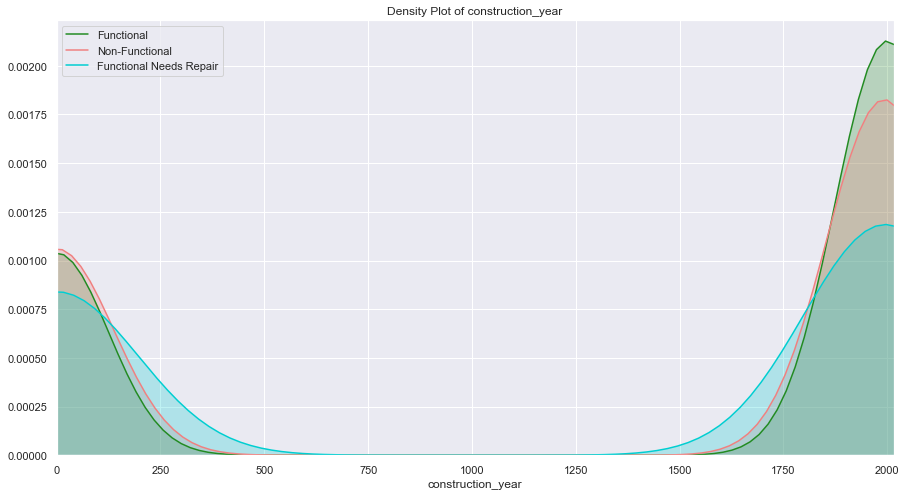

In [45]:
hf.density_plot(combined_df, 'construction_year', lower_bound = 0, upper_bound = 2015)

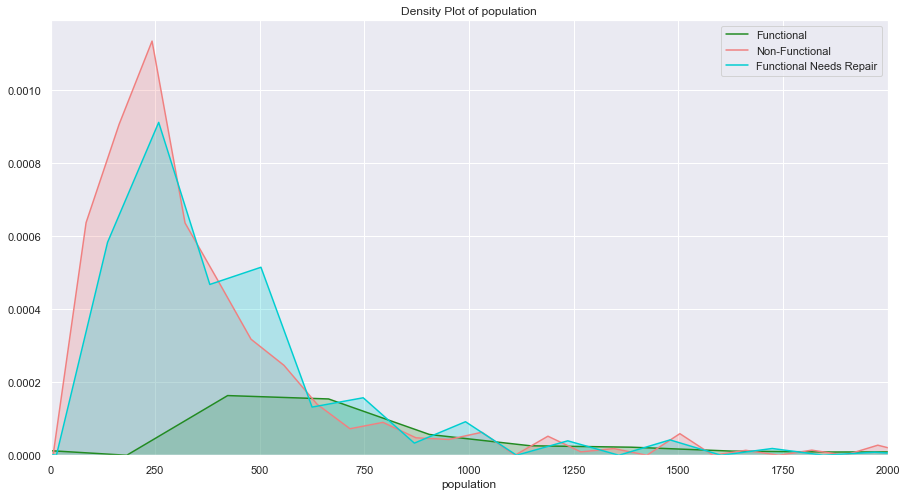

In [46]:
hf.density_plot(combined_df, 'population', lower_bound = 0, upper_bound = 2000)

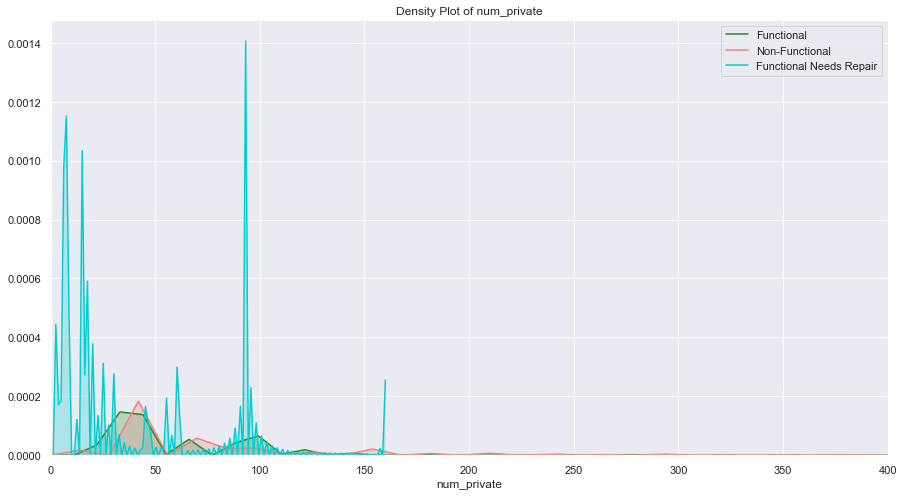

In [47]:
hf.density_plot(combined_df, 'num_private', lower_bound = 0, upper_bound = 400)

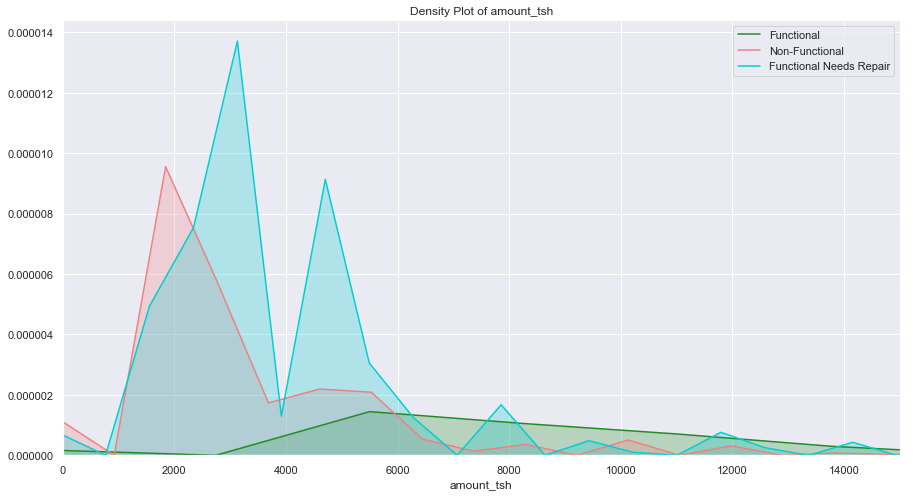

In [48]:
hf.density_plot(combined_df, 'amount_tsh', lower_bound = 0, upper_bound = 15000)

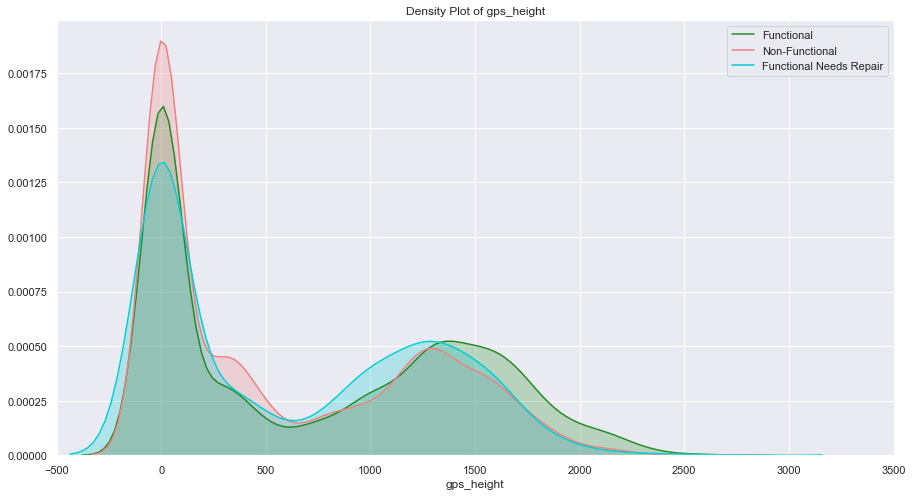

In [49]:
hf.density_plot(combined_df, 'gps_height', lower_bound = -500, upper_bound = 3500)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


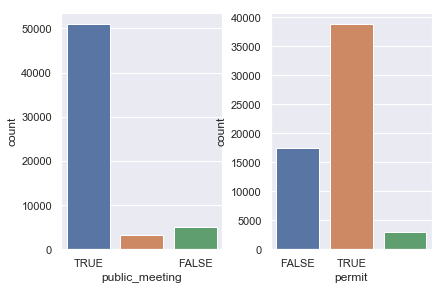

In [50]:
fig, ax = plt.subplots(1,2)
fig.tight_layout()
sns.countplot(combined_df[bools[0]], ax=ax[0])
sns.countplot(combined_df[bools[1]], ax=ax[1])

fig.show()

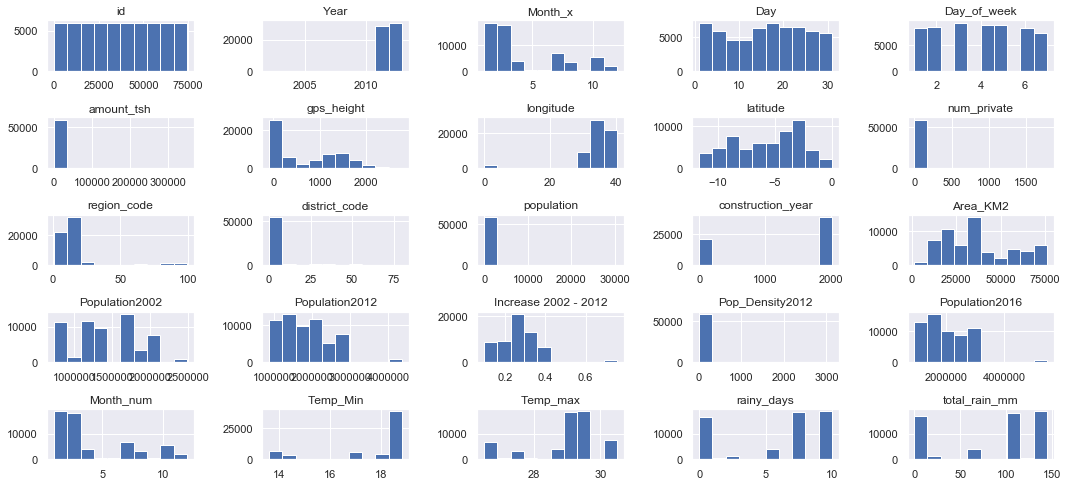

In [51]:
hf.draw_histograms(combined_df, nums, n_rows = 6, n_cols = 5)
scaled_numerics = ['amount_tsh', 'gps_height', 'num_private', 'population']

In [52]:
reduced_cat, large_drop, small_drop = hf.drop_categorical(combined_df, cat, upper_bound = 30, 
                                                          lower_bound = 2)

The following categories have too many unique values: ['subvillage', 'lga', 'installer', 'ward', 'scheme_name', 'funder', 'wpt_name', 'date_recorded']
The following categories have too few unique values: ['recorded_by', 'Status']


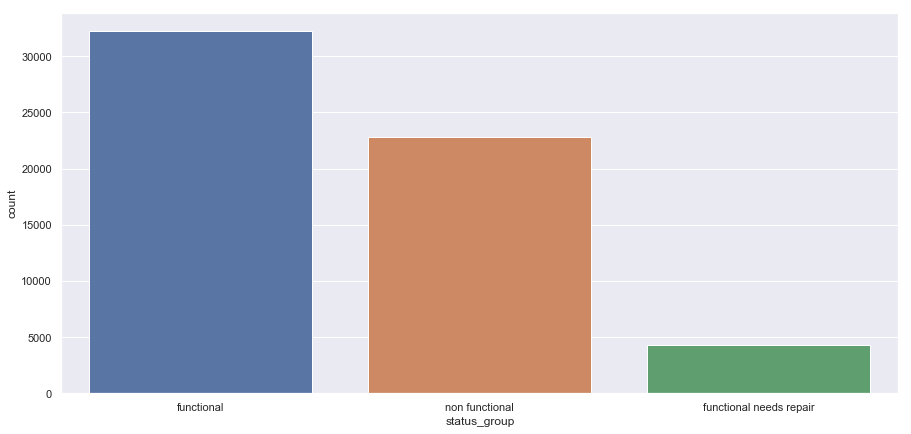

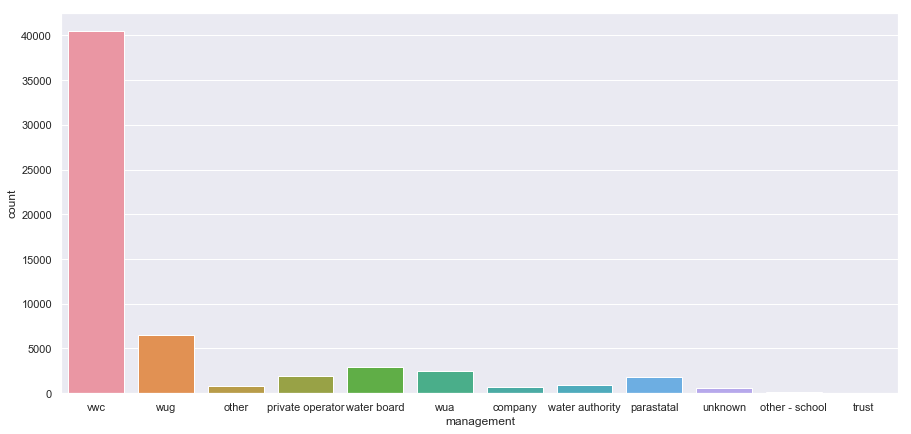

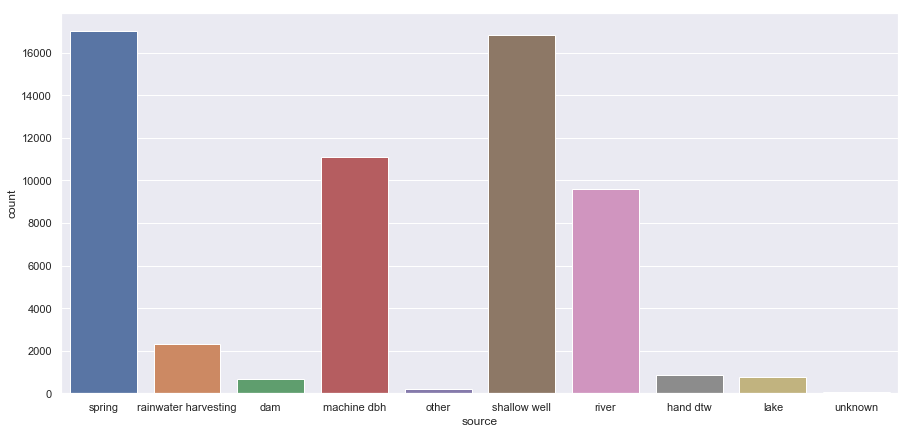

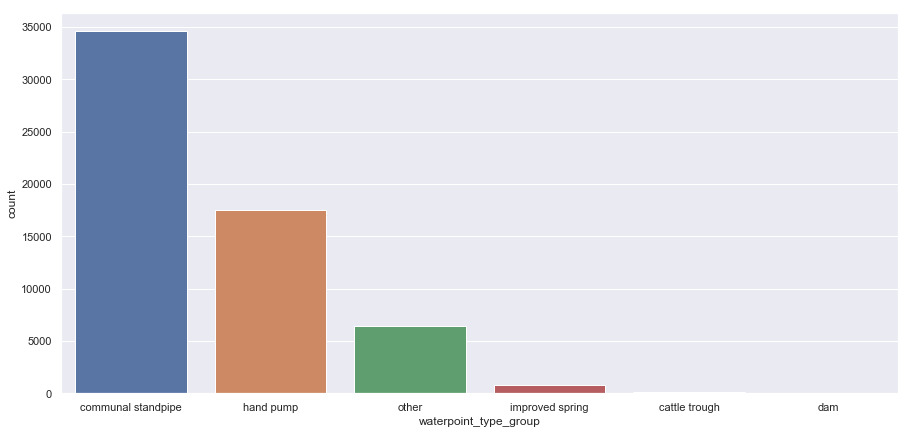

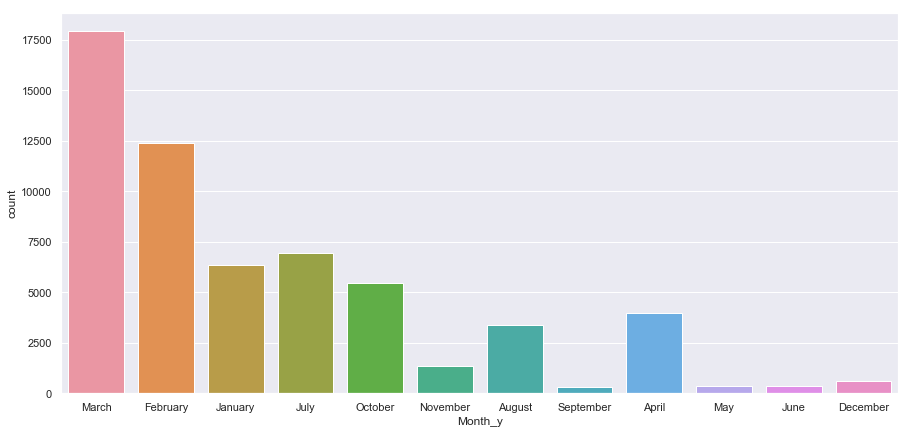

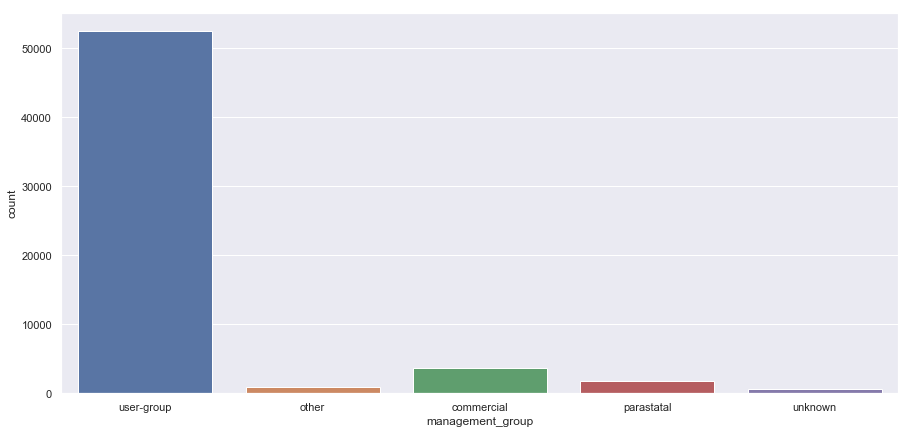

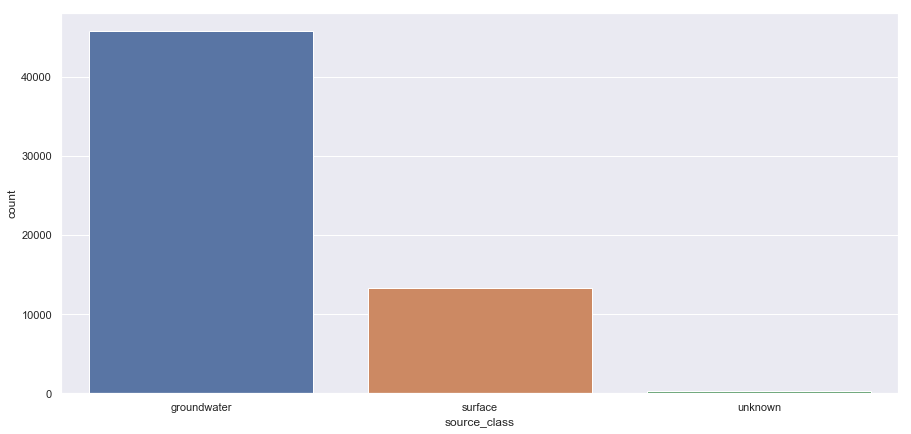

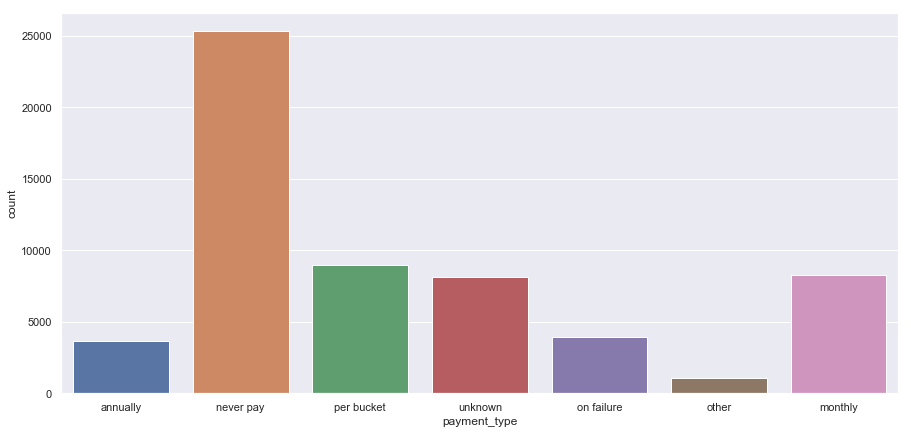

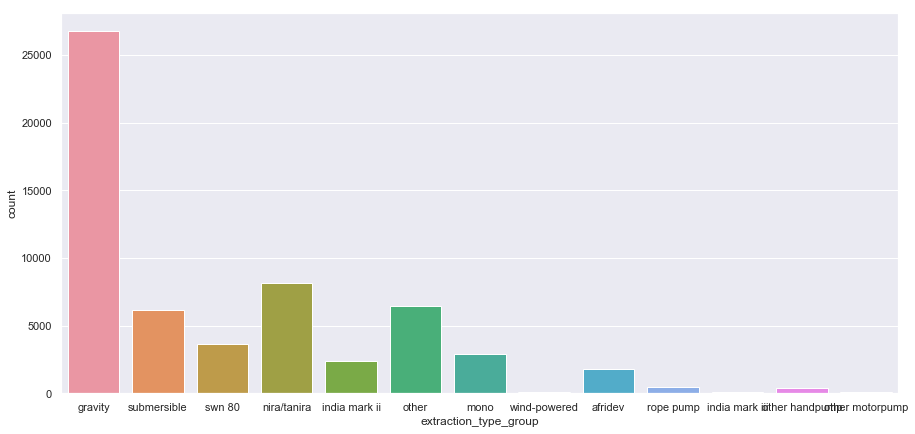

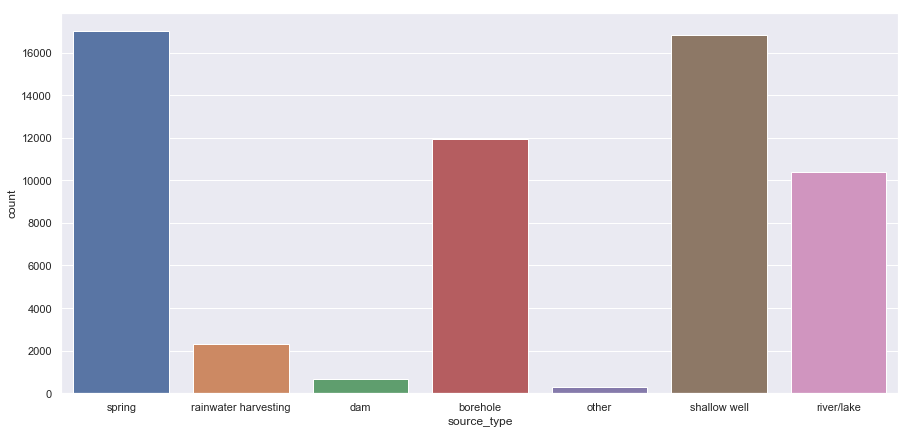

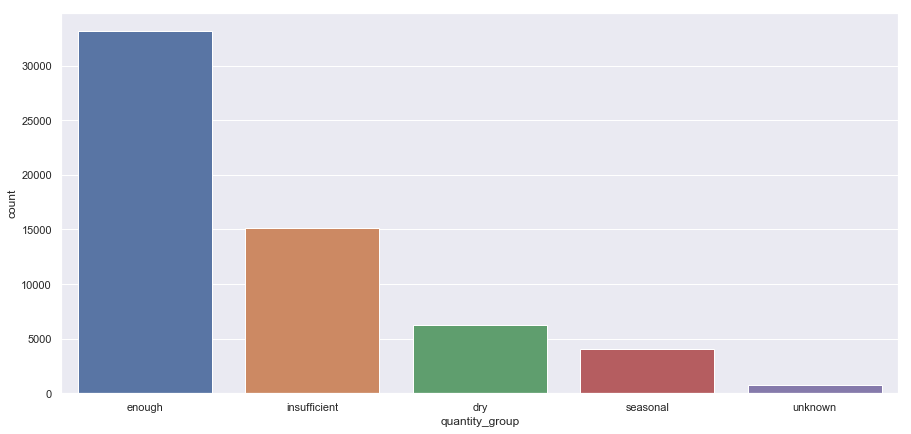

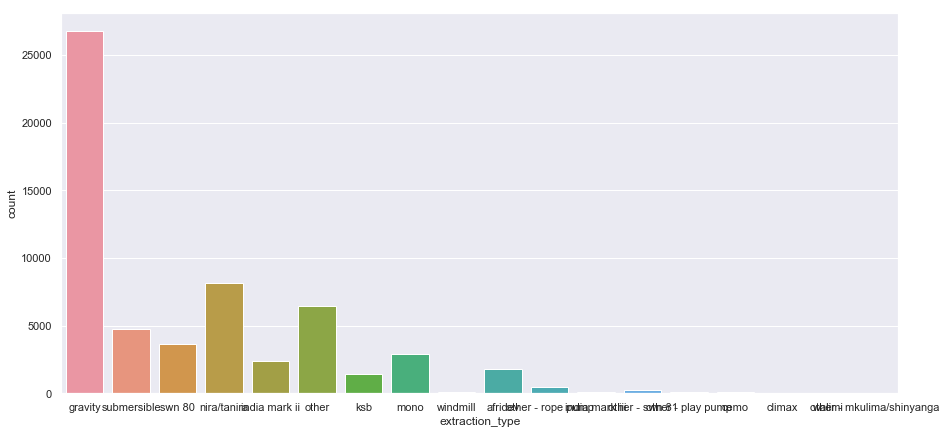

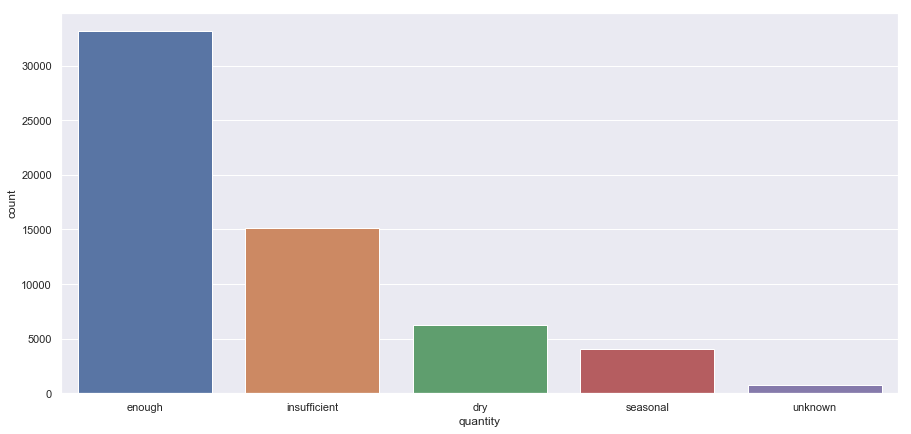

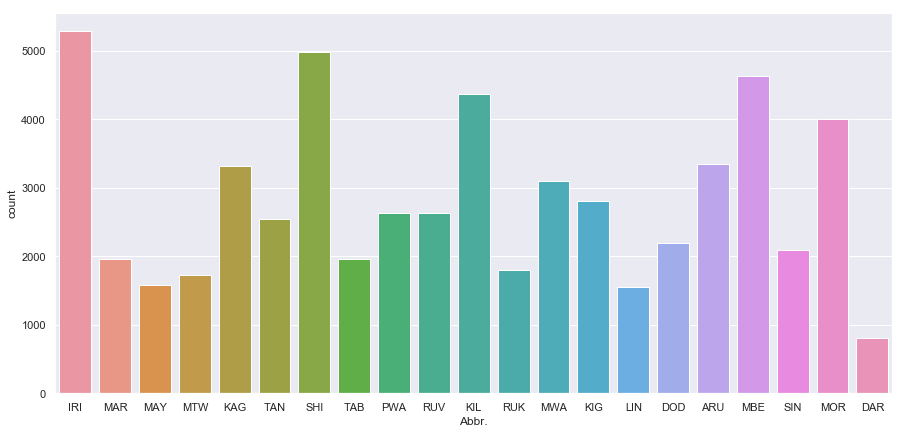

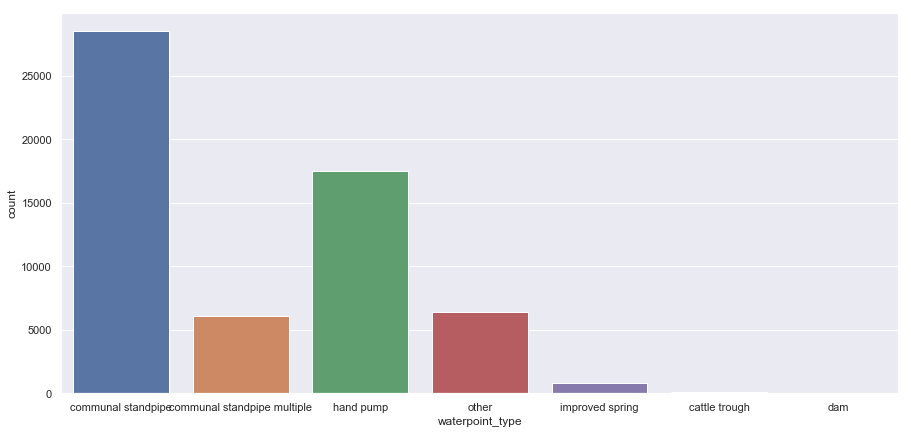

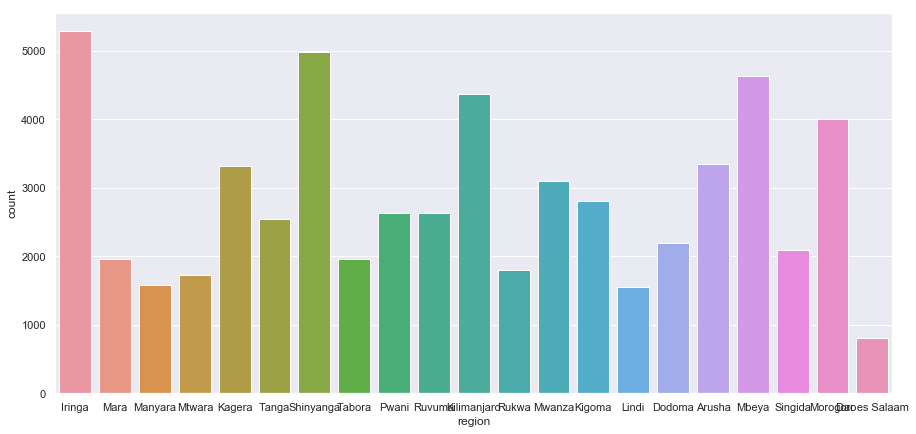

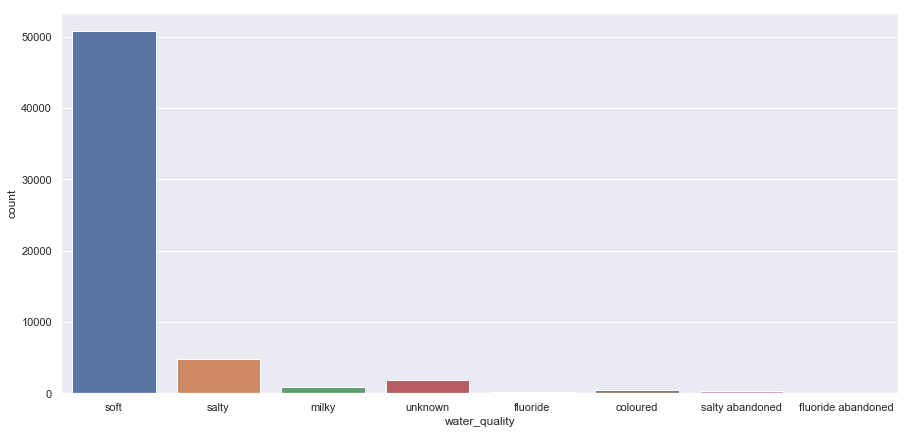

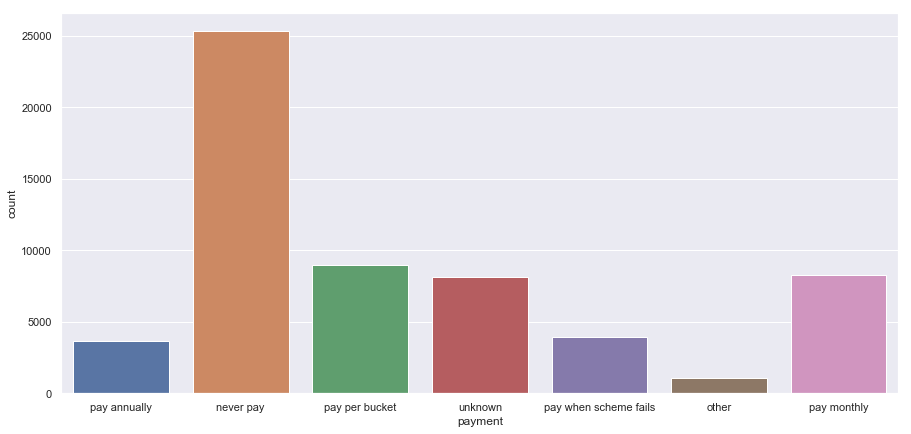

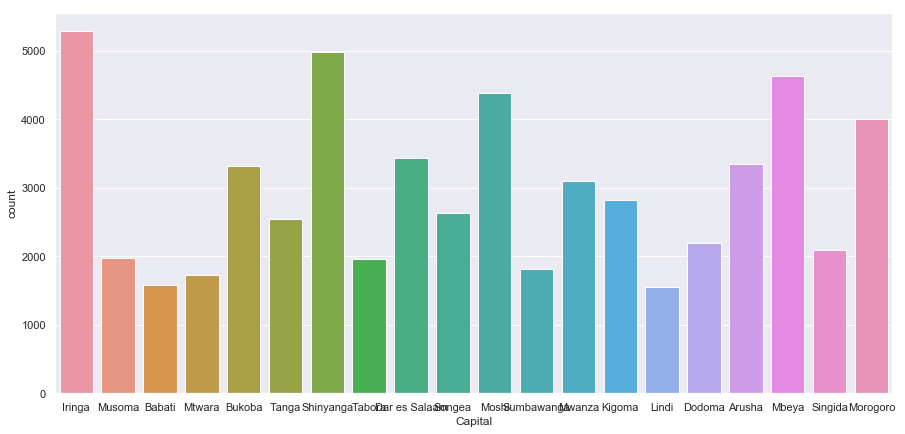

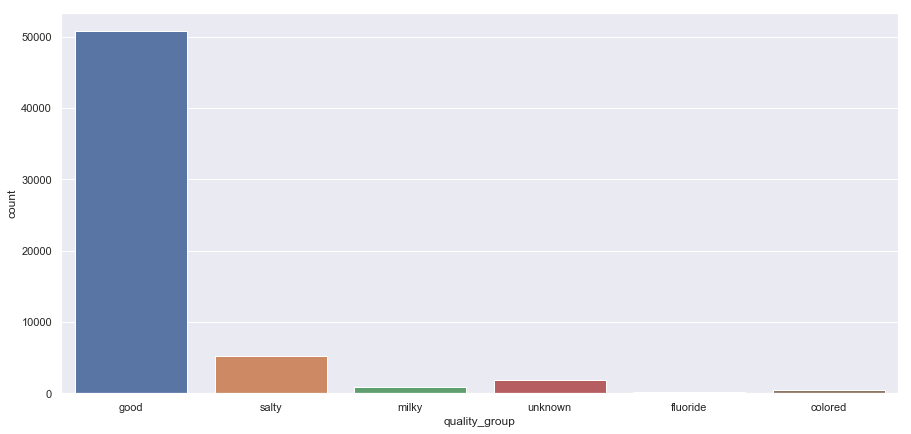

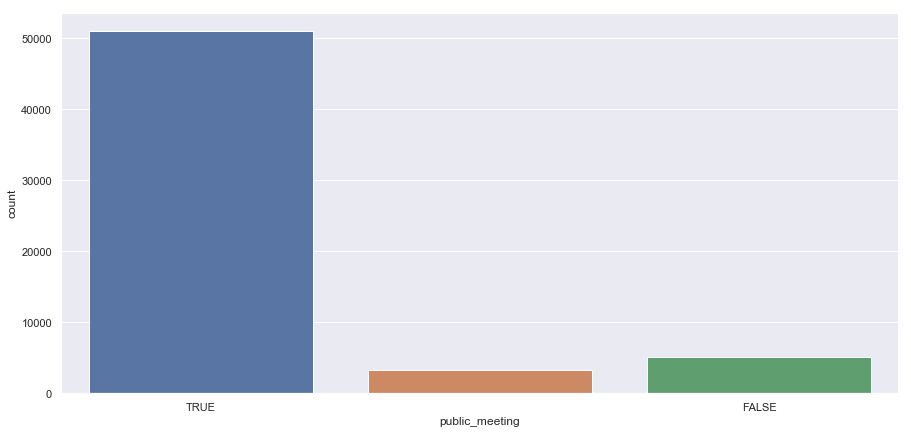

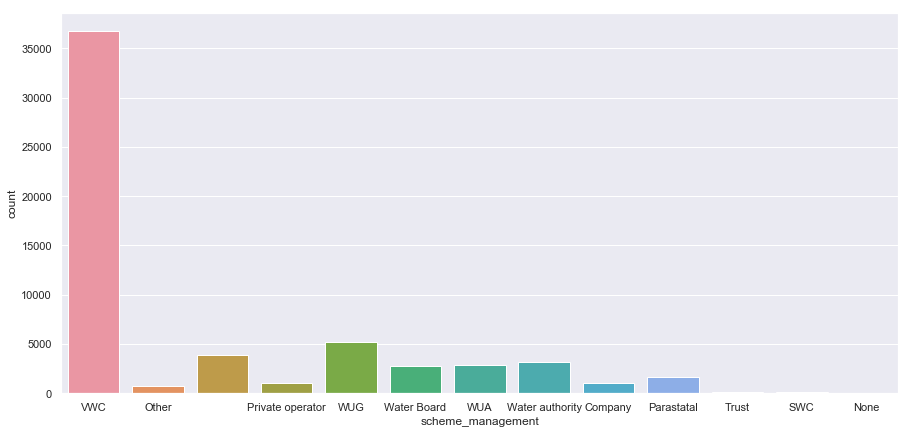

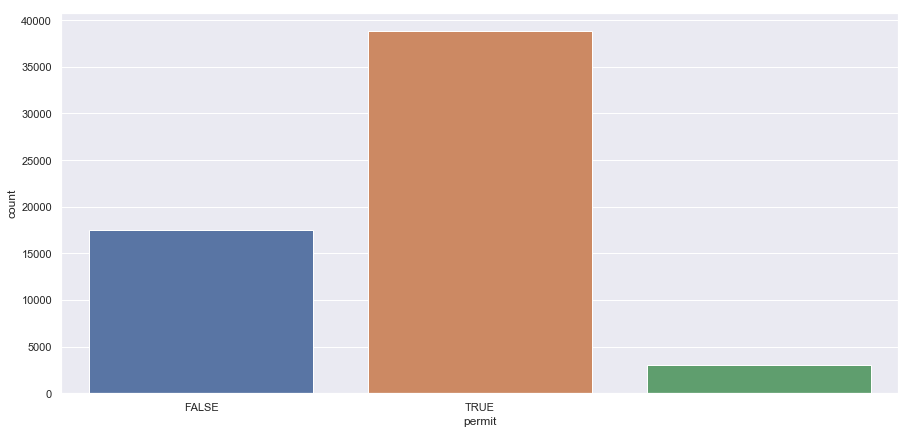

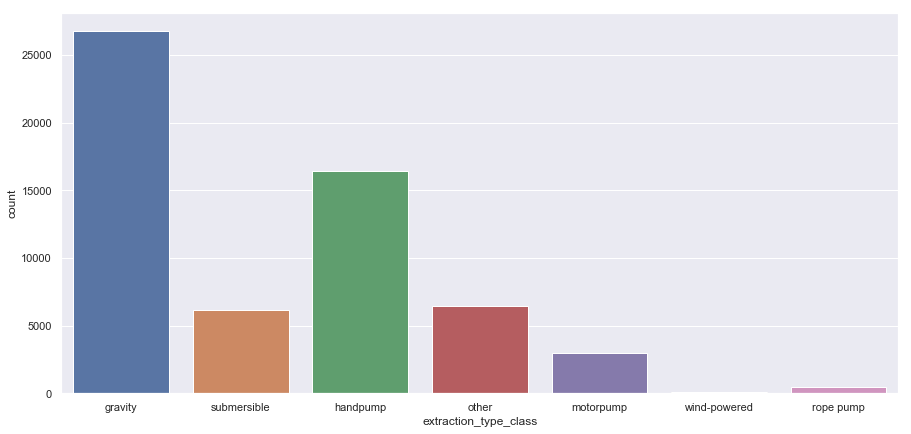

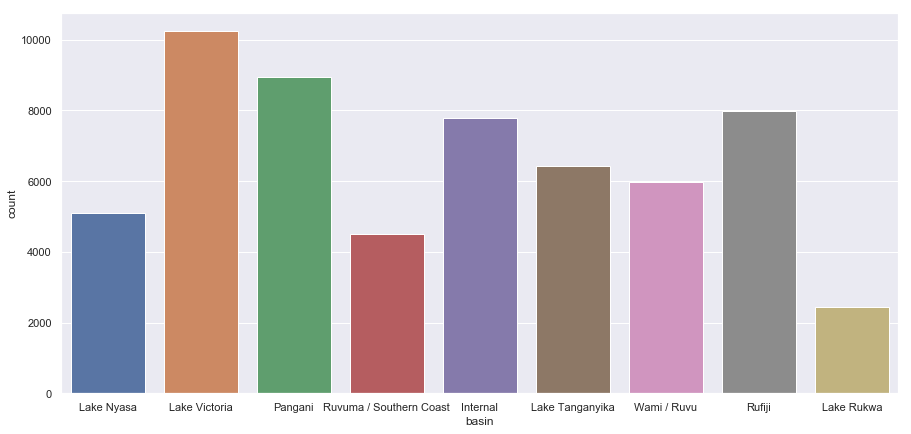

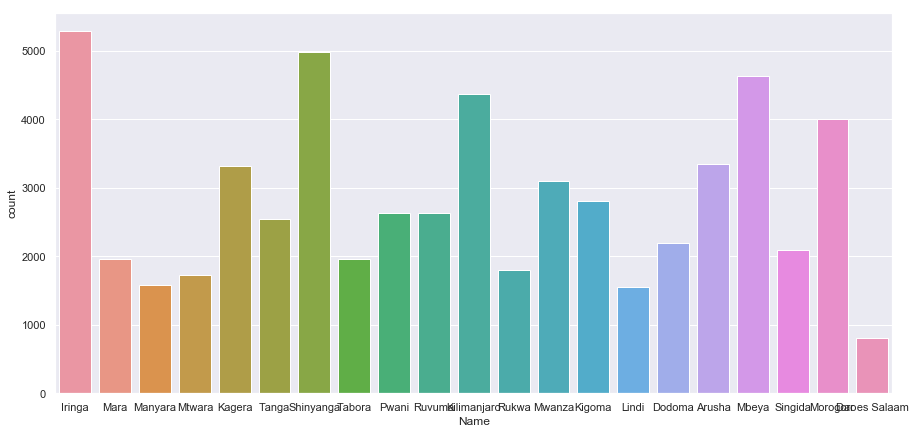

In [53]:
#Print distributions of categorical variables
for col in range(0, len(reduced_cat)):
    hf.categorical_plot(combined_df, reduced_cat, col) 

In [54]:
#Scale the salary variable
categorical_df = hf.categorical_to_scale(combined_df, 'status_group')
categorical_df.head()

,id,status_group,date_recorded,Year,Month_x,Day,Day_of_week,amount_tsh,funder,gps_height,...,Increase 2002 - 2012,Pop_Density2012,Population2016,Month_num,Month_y,Temp_Min,Temp_max,rainy_days,total_rain_mm,func_band
0,69572,functional,2011-03-14T00:00:00.000Z,2011,3,14,1,6000.0,Roman,1390,...,0.119983,26.511506,984900,3,March,18.3,29.0,7,113.9,2
1,8776,functional,2013-03-06T00:00:00.000Z,2013,3,6,3,0.0,Grumeti,1399,...,0.279033,80.139246,1924200,3,March,18.3,29.0,7,113.9,2
2,34310,functional,2013-02-25T00:00:00.000Z,2013,2,25,1,25.0,Lottery Club,686,...,0.373481,32.009591,1618000,2,February,18.6,29.4,9,144.5,2
3,67743,non functional,2013-01-28T00:00:00.000Z,2013,1,28,1,0.0,Unicef,263,...,0.130169,76.053501,1334600,1,January,18.6,29.4,10,133.7,0
4,19728,functional,2011-07-13T00:00:00.000Z,2011,7,13,3,0.0,Action In A,0,...,0.372085,97.289650,2789600,7,July,13.6,26.5,0,0.0,2


In [55]:
#Create dummy variables for categorical variables
encoded_df = hf.onehot_encode(categorical_df, reduced_cat)

#Keep track of boolean variables after encoding
booleans = hf.boolean_features(encoded_df)
encoded_df.head()

,id,date_recorded,Year,Month_x,Day,Day_of_week,amount_tsh,funder,gps_height,installer,...,Name_Morogoro,Name_Mtwara,Name_Mwanza,Name_Pwani,Name_Rukwa,Name_Ruvuma,Name_Shinyanga,Name_Singida,Name_Tabora,Name_Tanga
0,69572,2011-03-14T00:00:00.000Z,2011,3,14,1,6000.0,Roman,1390,Roman,...,0,0,0,0,0,0,0,0,0,0
1,8776,2013-03-06T00:00:00.000Z,2013,3,6,3,0.0,Grumeti,1399,GRUMETI,...,0,0,0,0,0,0,0,0,0,0
2,34310,2013-02-25T00:00:00.000Z,2013,2,25,1,25.0,Lottery Club,686,World vision,...,0,0,0,0,0,0,0,0,0,0
3,67743,2013-01-28T00:00:00.000Z,2013,1,28,1,0.0,Unicef,263,UNICEF,...,0,1,0,0,0,0,0,0,0,0
4,19728,2011-07-13T00:00:00.000Z,2011,7,13,3,0.0,Action In A,0,Artisan,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Extract the data we're interested in
lat = encoded_df['latitude'].values
lon = encoded_df['longitude'].values
amount = encoded_df['amount_tsh'].values
population = encoded_df['population'].values
target = encoded_df['func_band'].values

lat_med = stat.median(encoded_df['latitude'].values)
lon_med = stat.median(encoded_df['longitude'].values)

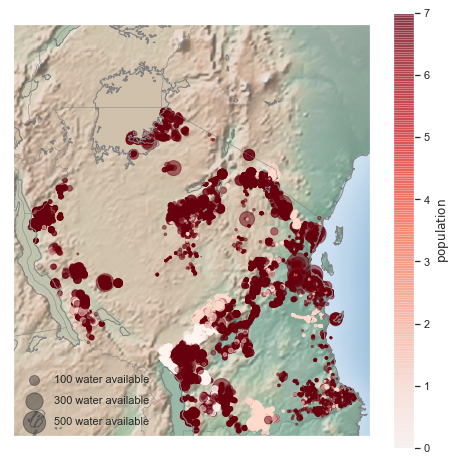

In [57]:
# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=lat_med, lon_0=lon_med,
            width=1.3E6, height=1.5E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting amount of water available
m.scatter(lon, lat, latlon=True, c=population, cmap = 'Reds', 
          s=np.sqrt(amount), alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'$\rm population}$')
plt.clim(0, 7)

# make legend with dummy points
for a in [100, 300, 500]:
    plt.scatter([], [], c='k', alpha=0.4, s=a,
                label=str(a) + ' water available')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

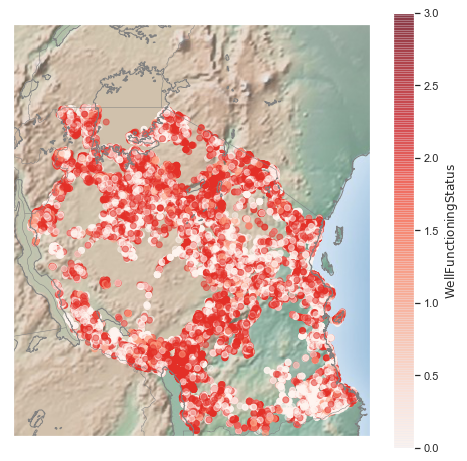

In [58]:
# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=lat_med, lon_0=lon_med,
            width=1.3E6, height=1.5E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting well status
m.scatter(lon, lat, latlon=True, c=target, cmap = 'Reds', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'$\rm Well Functioning Status}$')
plt.clim(0, 3)

In [59]:
prepared = encoded_df.copy()
prepared[scaled_numerics] = hf.fix_skewness(encoded_df[scaled_numerics])
prepared = hf.standardize(prepared, scaled_numerics)
prepared.head()

/Users/andrewmartinez/Documents/MBD/Machine Learning II/Group Project/Helper_Function.py:163: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  standardized_numericals = preprocessing.scale(df[numerical_values])


,id,date_recorded,Year,Month_x,Day,Day_of_week,amount_tsh,funder,gps_height,installer,...,Name_Morogoro,Name_Mtwara,Name_Mwanza,Name_Pwani,Name_Rukwa,Name_Ruvuma,Name_Shinyanga,Name_Singida,Name_Tabora,Name_Tanga
0,69572,2011-03-14T00:00:00.000Z,2011,3,14,1,2.637948,Roman,1.041252,Roman,...,0,0,0,0,0,0,0,0,0,0
1,8776,2013-03-06T00:00:00.000Z,2013,3,6,3,-0.604916,Grumeti,1.054237,GRUMETI,...,0,0,0,0,0,0,0,0,0,0
2,34310,2013-02-25T00:00:00.000Z,2013,2,25,1,0.667488,Lottery Club,0.025541,World vision,...,0,0,0,0,0,0,0,0,0,0
3,67743,2013-01-28T00:00:00.000Z,2013,1,28,1,-0.604916,Unicef,-0.584751,UNICEF,...,0,1,0,0,0,0,0,0,0,0
4,19728,2011-07-13T00:00:00.000Z,2011,7,13,3,-0.604916,Action In A,-0.964200,Artisan,...,0,0,0,0,0,0,0,0,0,0


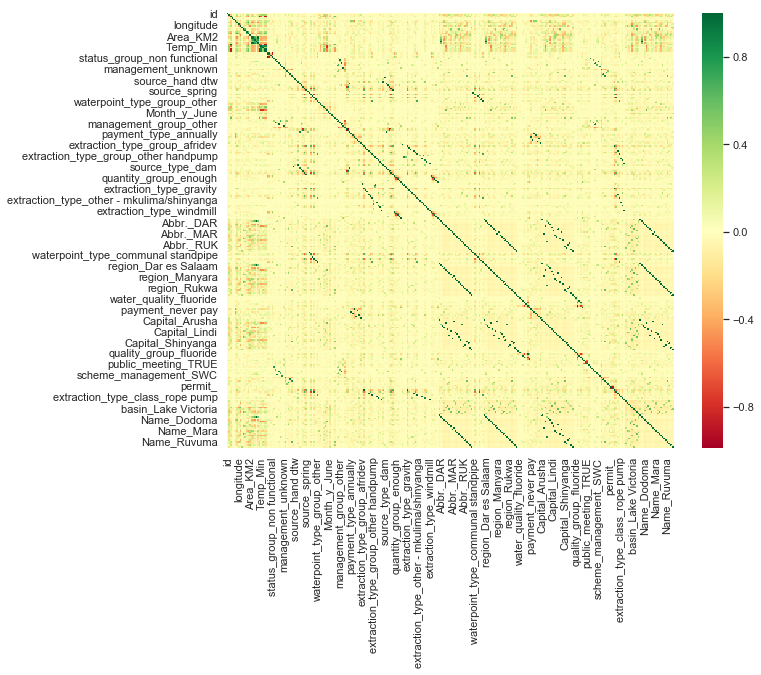

In [60]:
plt.figure(figsize=(10,8)) 
sns.heatmap(prepared.corr(), cmap="RdYlGn")
plt.show()